In [1]:
from transformers import pipeline, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer, util
import torch
import evaluate
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import textwrap
from summarization import sliding_window_summarization

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
# Replace 'file_path.pkl' with the path to your .pkl file
df = pd.read_pickle("../results_2024_11_09_112019/articles.pkl")

In [3]:
# convert dictionary to dataframe
df = pd.DataFrame(df)
df.head(3)

,PMC11315657,PMC11204383,PMC11301388,PMC11240861,PMC11289611,PMC11286288,PMC11315276,PMC11312292,PMC11308427,PMC11303826,...,PMC11180946,PMC11097100,PMC11096445,PMC11284501,PMC10749615,PMC11152865,PMC11293442,PMC11152559,PMC10749592,PMC11213448
TITLE,[Exploring the association between melatonin a...,[Antibodies Against ZSCAN1 in Pediatric and Ad...,[Gingival mesenchymal stem cells: Biological p...,[Research progress of DNA methylation in color...,[Investigating the Relationship of Serum CD163...,[Genetic Associations With an Amyotrophic Late...,[The aperiodic exponent of neural activity var...,[mTOR activation induces endolysosomal remodel...,[Mendelian randomization study on causal assoc...,[Pooling Alzheimer's disease clinical trial da...,...,[The 2022 symposium on dementia and brain agin...,[Hyperbaric oxygen therapy: future prospects i...,[Dangers of the chronic stress response in the...,[Cortical similarities in psychiatric and mood...,[The autophagy protein Atg9 functions in glia ...,[Role of erythropoietin in the treatment of Al...,[CNTN4 modulates neural elongation through int...,[Evaluating protein prenylation of human and v...,[Mitophagy in neurodegenerative disease pathog...,[“The burden of lifestyle diseases and their i...
ABSTRACT,[Due to the addictive qualities of tobacco pro...,"[Objectives, To report the association of zinc...",[Our understanding of mesenchymal stem cells (...,[DNA methylation is one of the earliest and mo...,"[Objective, This study aimed to compare serum ...","[Background and Objectives, The term “ALS Reve...",[Recently the 1/f signal of human electroencep...,[Astrocytes respond and contribute to neuroinf...,"[Background, Previous research has revealed th...","[Abstract, With the advent of the first genera...",...,"[Abstract, Two of every three persons living w...",[Hyperbaric Oxygen Therapy (HBOT) utilizes 100...,[More than 20% of American adults live with a ...,"[Summary, Structural neuroimaging studies have...",[Parkinson’s disease is a progressive neurodeg...,[This review aims to explore the potential of ...,[The neuronal cell adhesion molecule contactin...,"[ABSTRACT, Prenylated proteins are prevalent i...",[Mitochondria are critical cellular energy res...,"[ABSTRACT, Basically, non-communicable disease..."
INTRO,"[Introduction, Nicotine dependence, a pervasiv...","[Introduction, Rapid-onset obesity with hypoth...","[Introduction, Mesenchymal stem cells, In the ...","[Introduction, Colorectal cancer (CRC) is one ...","[INTRODUCTION, Autism spectrum disorder (ASD) ...","[Introduction, Amyotrophic lateral sclerosis (...","[Introduction, Pink noise or 1/f signals is a ...","[Introduction, Astrocytes maintain homeostasis...","[Introduction, Pulmonary arterial hypertension...","[INTRODUCTION, Alzheimer's disease is the most...",...,"[INTRODUCTION, Approximately 50 million people...","[Introduction, Hyperbaric oxygen therapy (HBOT...","[Introduction, Over 1 in 5 youth and adults li...","[Introduction, Mental illness can be severe, c...","[Introduction, Parkinson’s disease (PD) is a n...","[Introduction, Highlights, Oxidative stress da...","[Introduction, Neurodevelopmental disorders su...","[INTRODUCTION, Post-translational modification...","[Introduction, Neurons are the basic structura...","[Introduction and Background, Lifestyle diseas..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, TITLE to CONCL
Columns: 500 entries, PMC11315657 to PMC11213448
dtypes: object(500)
memory usage: 31.3+ KB


In [5]:
# transpose the dataframe and add an index column
df = df.T.reset_index()
df.head()

,index,TITLE,ABSTRACT,INTRO,CASE,METHODS,RESULTS,DISCUSS,CONCL
0,PMC11315657,[Exploring the association between melatonin a...,[Due to the addictive qualities of tobacco pro...,"[Introduction, Nicotine dependence, a pervasiv...",[],[Considering individual differences in treatme...,[],[],"[Future research directions and conclusions, F..."
1,PMC11204383,[Antibodies Against ZSCAN1 in Pediatric and Ad...,"[Objectives, To report the association of zinc...","[Introduction, Rapid-onset obesity with hypoth...",[],"[Methods, Patients and Samples, Thirteen patie...","[Results, ZSCAN1-abs were identified in 5 of 6...","[Discussion, The discovery of ZSCAN1-abs as a ...",[]
2,PMC11301388,[Gingival mesenchymal stem cells: Biological p...,[Our understanding of mesenchymal stem cells (...,"[Introduction, Mesenchymal stem cells, In the ...",[],"[Source, isolation, culture method, and prelim...",[],"[Limitations on GMSC practical use, Despite th...","[Conclusion, Over the last two decades, intere..."
3,PMC11240861,[Research progress of DNA methylation in color...,[DNA methylation is one of the earliest and mo...,"[Introduction, Colorectal cancer (CRC) is one ...",[],"[Availability of data and materials, Not appli...",[],[],"[Conclusions and outlook, The research prospec..."
4,PMC11289611,[Investigating the Relationship of Serum CD163...,"[Objective, This study aimed to compare serum ...","[INTRODUCTION, Autism spectrum disorder (ASD) ...",[],"[METHODS, Sample of the Study, Forty children ...","[RESULTS, Table 1 presents the data regarding ...","[DISCUSSION, In this study, the serum CD163, Y...",[]


In [6]:
# change the first column name to 'article_id'
df = df.rename(columns={"index": "article_id"})
df.head(3)

,article_id,TITLE,ABSTRACT,INTRO,CASE,METHODS,RESULTS,DISCUSS,CONCL
0,PMC11315657,[Exploring the association between melatonin a...,[Due to the addictive qualities of tobacco pro...,"[Introduction, Nicotine dependence, a pervasiv...",[],[Considering individual differences in treatme...,[],[],"[Future research directions and conclusions, F..."
1,PMC11204383,[Antibodies Against ZSCAN1 in Pediatric and Ad...,"[Objectives, To report the association of zinc...","[Introduction, Rapid-onset obesity with hypoth...",[],"[Methods, Patients and Samples, Thirteen patie...","[Results, ZSCAN1-abs were identified in 5 of 6...","[Discussion, The discovery of ZSCAN1-abs as a ...",[]
2,PMC11301388,[Gingival mesenchymal stem cells: Biological p...,[Our understanding of mesenchymal stem cells (...,"[Introduction, Mesenchymal stem cells, In the ...",[],"[Source, isolation, culture method, and prelim...",[],"[Limitations on GMSC practical use, Despite th...","[Conclusion, Over the last two decades, intere..."


In [7]:
# Convert all lists in the DataFrame to strings
df = df.apply(
    lambda x: x.map(lambda y: ", ".join(map(str, y)) if isinstance(y, list) else y),
    axis=0,
)

df.head(3)

,article_id,TITLE,ABSTRACT,INTRO,CASE,METHODS,RESULTS,DISCUSS,CONCL
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...,"Introduction, Nicotine dependence, a pervasive...",,Considering individual differences in treatmen...,,,"Future research directions and conclusions, Fu..."
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ...","Introduction, Rapid-onset obesity with hypotha...",,"Methods, Patients and Samples, Thirteen patien...","Results, ZSCAN1-abs were identified in 5 of 6 ...","Discussion, The discovery of ZSCAN1-abs as a b...",
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...,"Introduction, Mesenchymal stem cells, In the e...",,"Source, isolation, culture method, and prelimi...",,"Limitations on GMSC practical use, Despite the...","Conclusion, Over the last two decades, interes..."


In [8]:
# Check for missing values after converting lists to strings
df.isnull().sum()

article_id    0
TITLE         0
ABSTRACT      0
INTRO         0
CASE          0
METHODS       0
RESULTS       0
DISCUSS       0
CONCL         0
dtype: int64

In [9]:
# Replace empty strings with NaN
df = df.replace("", float("NaN"))
df.head(3)

,article_id,TITLE,ABSTRACT,INTRO,CASE,METHODS,RESULTS,DISCUSS,CONCL
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...,"Introduction, Nicotine dependence, a pervasive...",NaN,Considering individual differences in treatmen...,NaN,NaN,"Future research directions and conclusions, Fu..."
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ...","Introduction, Rapid-onset obesity with hypotha...",NaN,"Methods, Patients and Samples, Thirteen patien...","Results, ZSCAN1-abs were identified in 5 of 6 ...","Discussion, The discovery of ZSCAN1-abs as a b...",NaN
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...,"Introduction, Mesenchymal stem cells, In the e...",NaN,"Source, isolation, culture method, and prelimi...",NaN,"Limitations on GMSC practical use, Despite the...","Conclusion, Over the last two decades, interes..."


In [10]:
# Check for missing values after replacing empty strings with NaN
df.isnull().sum()

article_id      0
TITLE           0
ABSTRACT        0
INTRO           3
CASE          496
METHODS       146
RESULTS       201
DISCUSS       137
CONCL         198
dtype: int64

In [11]:
# CASE column: 496 missing out of 500 (99.2% missing) — Droping the column
df = df.drop(columns=["CASE"])
df.head(3)

,article_id,TITLE,ABSTRACT,INTRO,METHODS,RESULTS,DISCUSS,CONCL
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...,"Introduction, Nicotine dependence, a pervasive...",Considering individual differences in treatmen...,NaN,NaN,"Future research directions and conclusions, Fu..."
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ...","Introduction, Rapid-onset obesity with hypotha...","Methods, Patients and Samples, Thirteen patien...","Results, ZSCAN1-abs were identified in 5 of 6 ...","Discussion, The discovery of ZSCAN1-abs as a b...",NaN
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...,"Introduction, Mesenchymal stem cells, In the e...","Source, isolation, culture method, and prelimi...",NaN,"Limitations on GMSC practical use, Despite the...","Conclusion, Over the last two decades, interes..."


In [12]:
# replace NaN values with empty strings
df = df.fillna("")
df.head(3)

,article_id,TITLE,ABSTRACT,INTRO,METHODS,RESULTS,DISCUSS,CONCL
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...,"Introduction, Nicotine dependence, a pervasive...",Considering individual differences in treatmen...,,,"Future research directions and conclusions, Fu..."
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ...","Introduction, Rapid-onset obesity with hypotha...","Methods, Patients and Samples, Thirteen patien...","Results, ZSCAN1-abs were identified in 5 of 6 ...","Discussion, The discovery of ZSCAN1-abs as a b...",
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...,"Introduction, Mesenchymal stem cells, In the e...","Source, isolation, culture method, and prelimi...",,"Limitations on GMSC practical use, Despite the...","Conclusion, Over the last two decades, interes..."


In [13]:
# save the dataframe to a .csv file
# df.to_csv(
#     "articles.csv", index=False
# )

In [14]:
# Method to recreate the articles minus the abstracts
def combine_columns(df):
    """
    Combines the text from multiple columns into a single column for natural language processing.

    Args:
      df: A pandas DataFrame with columns 'article_id', 'TITLE', 'INTRO', 'CASE', 'METHODS', 'RESULTS', 'DISCUSS', 'CONCL'.

    Returns:
      A pandas DataFrame with a new column 'full_text' containing the combined text.
    """

    df["full_text"] = df.apply(
        lambda row: " ".join(
            [
                str(row["TITLE"]),
                str(row["INTRO"]),
                str(row["METHODS"]),
                str(row["RESULTS"]),
                str(row["DISCUSS"]),
                str(row["CONCL"]),
            ]
        ),
        axis=1,
    )
    return df

In [15]:
df_articles = combine_columns(df)
df_articles.head(3)

,article_id,TITLE,ABSTRACT,INTRO,METHODS,RESULTS,DISCUSS,CONCL,full_text
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...,"Introduction, Nicotine dependence, a pervasive...",Considering individual differences in treatmen...,,,"Future research directions and conclusions, Fu...",Exploring the association between melatonin an...
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ...","Introduction, Rapid-onset obesity with hypotha...","Methods, Patients and Samples, Thirteen patien...","Results, ZSCAN1-abs were identified in 5 of 6 ...","Discussion, The discovery of ZSCAN1-abs as a b...",,Antibodies Against ZSCAN1 in Pediatric and Adu...
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...,"Introduction, Mesenchymal stem cells, In the e...","Source, isolation, culture method, and prelimi...",,"Limitations on GMSC practical use, Despite the...","Conclusion, Over the last two decades, interes...",Gingival mesenchymal stem cells: Biological pr...


In [16]:
# Strip whitespace from each cell in the DataFrame
df_articles = df_articles.apply(
    lambda x: x.map(lambda y: y.strip() if isinstance(y, str) else y), axis=0
)
df_articles.head(3)

,article_id,TITLE,ABSTRACT,INTRO,METHODS,RESULTS,DISCUSS,CONCL,full_text
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...,"Introduction, Nicotine dependence, a pervasive...",Considering individual differences in treatmen...,,,"Future research directions and conclusions, Fu...",Exploring the association between melatonin an...
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ...","Introduction, Rapid-onset obesity with hypotha...","Methods, Patients and Samples, Thirteen patien...","Results, ZSCAN1-abs were identified in 5 of 6 ...","Discussion, The discovery of ZSCAN1-abs as a b...",,Antibodies Against ZSCAN1 in Pediatric and Adu...
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...,"Introduction, Mesenchymal stem cells, In the e...","Source, isolation, culture method, and prelimi...",,"Limitations on GMSC practical use, Despite the...","Conclusion, Over the last two decades, interes...",Gingival mesenchymal stem cells: Biological pr...


In [17]:
wrapper = textwrap.TextWrapper(width=80, break_long_words=False, break_on_hyphens=False)

In [18]:
# Method to print the full text of a single article by article_id
def print_article(df, article_id):
    """
    Prints the full text of a single article in a readable format.

    Args:
      df: A pandas DataFrame with a 'full_text' column and an 'article_id' column.
      article_id: The ID of the article to print.
    """

    article = df[df["article_id"] == article_id]["full_text"].values[0]

    print(wrapper.fill(article))

In [19]:
# get a random article_id
article_id = df_articles.sample()["article_id"].values[0]
# print the full text of a random article_id
print_article(df_articles, article_id)

The Study of Myo-Inositol’s Anxiolytic Activity on Zebrafish (Danio rerio) 1.
Introduction, Herbal medicine and a healthy lifestyle based on a balanced diet
full of fruits, vegetables, nuts and seeds have been promoted for years.
Cyclitols are a group of compounds that may have a beneficial effect on human
health and support immunity against numerous diseases, but its use as a clinical
therapeutic is not established. Also known as sugar alcohols or polyols, they
are widely distributed in the environment, and are found in many organic
products such as citrus fruits, nuts, yeast, grains, beans, buckwheat, and many
others. Cyclitols and their derivatives perform many functions in eukaryotic
cells. They regulate ion channel activity, intracellular phosphate storage, cell
wall formation, signal transduction, membrane biogenesis and osmoregulation;
furthermore, they are the forerunners of crucial secondary messengers.
Myo-inositol (MI) is a representative of the cyclitol group, at the same t

In [20]:
# print article abstract
def print_abstract(df, article_id):
    """
    Prints the abstract of a single article in a readable format.

    Args:
      df: A pandas DataFrame with an 'article_id' column and a 'ABSTRACT' column.
      article_id: The ID of the article to print.
    """

    abstract = df[df["article_id"] == article_id]["ABSTRACT"].values[0]

    print(wrapper.fill(abstract))


print_abstract(df, article_id)

Introduction: Myo-inositol (MI) is the most abundant inositol found in nature.
To date MI supplementation is reported to be effective in the treatment of
polycystic ovary syndrome, it is also suggested to alleviate the symptoms of
diabetes and neurodegenerative disorders, but to date no statistically
significant effects of inositol on depressive and anxiety symptoms were proven.
In the study of anxiolytic effects in zebrafish, we often use the thigmotaxis
index measuring the ratio of the amount of time the animal spends near the walls
compared to the entire arena. Aim: The objective of this paper was to examine
the effect of MI on zebrafish embryos’ locomotor activity, as well as its
potential anxiolytic activity in zebrafish larvae. Material and methods: In the
first part of the experiment, the embryos were incubated with 5, 10, 20, and 40
mg/mL MI. 1-day post fertilization, embryo mobility was evaluated and burst
activity was calculated. In the next part of the study, the behavior of

array([[<Axes: title={'center': 'full_text_length'}>,
        <Axes: title={'center': 'abstract_length'}>]], dtype=object)

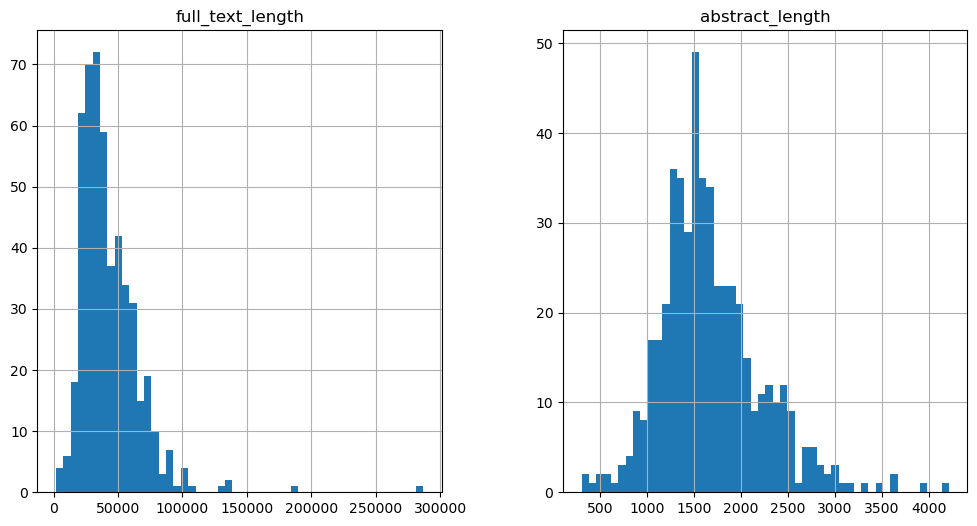

In [21]:
# create two lists 'full_text_length' and 'abstract_length' to store the length of each article and its abstract
full_text_length = []
abstract_length = []

# iterate through each row in the DataFrame
for index, row in df_articles.iterrows():
    # calculate the length of the 'full_text' and 'ABSTRACT' columns
    full_text_length.append(len(row["full_text"]))
    abstract_length.append(len(row["ABSTRACT"]))

data = pd.DataFrame([full_text_length, abstract_length]).T
data.columns = ["full_text_length", "abstract_length"]

data.hist(bins=50, figsize=(12, 6))

In [22]:
# Average length of full_text
data["full_text_length"].mean()
# Average length of abstract
data["abstract_length"].mean()

print("Average length of full_text:", data["full_text_length"].mean())
print("Average length of abstract:", data["abstract_length"].mean())

Average length of full_text: 42918.23
Average length of abstract: 1677.278


In [23]:
# Check for GPU support on Windows/Linux (CUDA) or MacOS (MPS)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [24]:
# Get a random index from the DataFrame
index = df_articles.sample().index[0]
# Get the full text of the article at the random index
article = df_articles.loc[index, "full_text"]
abstract = df_articles.loc[index, "ABSTRACT"]

In [25]:
print("Article:")
print(wrapper.fill(article))

Article:
Politicizing science funding undermines public trust in science, academic
freedom, and the unbiased generation of knowledge Do we want the mixture of
students who are going to be trained to do advanced medical research to be
representative of the demographic make-up of the population as a whole—or do we
want whatever students, from whatever backgrounds, who have track records
demonstrating a mastery of medical science that gives them the highest
probability of finding cures for cancer, Alzheimer's, and other devastating
diseases? Endeavors have purposes. Is indulging ideological visions more
important than ending cancer and Alzheimer's?, 1 Introduction, Science is
essential for humankind to thrive. Science is the foundation of technologies
that deliver food, energy, and medicine. Scientific progress has contributed to
the greatly improved human condition worldwide, including higher standards of
living, lengthened lifespans, and the eradication of deadly diseases and famine.
Sc

In [26]:
print("Abstract:")
print(wrapper.fill(abstract))

Abstract:
This commentary documents how federal funding agencies are changing the criteria
by which they distribute taxpayer money intended for scientific research.
Increasingly, STEMM (Science, Technology, Engineering, Mathematics, and
Medicine) funding agencies are requiring applicants for funding to include a
plan to advance DEI (“Diversity, Equity, and Inclusion”) in their proposals and
to dedicate a part of the research budget to its implementation. These mandates
undermine the academic freedom of researchers and the unbiased generation of
knowledge needed for a well-functioning democracy. Maintaining excellence in
science is fundamental to the continuation of the U.S. as a global economic
leader. Science provides a basis for solving important global challenges such as
security, energy, climate, and health. Diverting funding from science into
activities unrelated to the production of knowledge undermines science's ability
to serve humankind. When funding agencies politicize scienc

In [27]:
# find the number of tokens in the article
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
tokens = tokenizer(article, return_tensors="pt")
num_tokens = tokens.input_ids.shape[1]
print("Number of tokens in the article:", num_tokens)

Number of tokens in the article: 9773


In [28]:
# find the number of tokens in the abstract
tokens = tokenizer(abstract, return_tensors="pt")
num_tokens = tokens.input_ids.shape[1]
print("Number of tokens in the abstract:", num_tokens)

Number of tokens in the abstract: 215


In [29]:
def summarize_article_with_model(
    article: str,
    model_name: str = "t5-small",
    max_length: int = 512,
    overlap: int = 128,
    redundancy_threshold: float = 0.8,
    summary_length: int = 300,
) -> str:
    """
    Summarizes an article using a specified model and the sliding window summarization method.

    Args:
        article (str): The article to summarize.
        model_name (str): The model name to use for summarization (default is 't5-small').
        max_length (int): Maximum token length for each chunk (default is 512).
        overlap (int): The number of tokens to overlap between chunks (default is 128).
        redundancy_threshold (float): The cosine similarity threshold for redundancy reduction (default is 0.8).
        summary_length (int): The maximum length of the summary (default is 100 characters).

    Returns:
        str: The summarized article.
    """
    # Initialize tokenizer and pipeline for summarization
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    summarization_pipeline = pipeline("summarization", model=model_name)

    # Call the sliding window summarization function
    summary = sliding_window_summarization(
        text=article,
        tokenizer=tokenizer,
        pipe=summarization_pipeline,
        max_length=max_length,
        overlap=overlap,
        redundancy_threshold=redundancy_threshold,
        summary_length=summary_length,
    )

    return summary

In [30]:
# Summarize the article using the BART model
model_name = "facebook/bart-large-cnn"

# Iitialize the tokenizer and pipeline for summarization
tokenizer = AutoTokenizer.from_pretrained(model_name)
summarization_pipeline = pipeline("summarization", model=model_name, device=device)

# Call the sliding window summarization function
summary = sliding_window_summarization(
    text=article,
    tokenizer=tokenizer,
    pipe=summarization_pipeline,
    max_length=512,
    overlap=128,
    redundancy_threshold=0.8,
    summary_length=900,
)

print("Summary:")
print(wrapper.fill(summary))

/Users/stanlouis/Documents/Code/research_summarizer/research_summarizer/summarization.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(previous_summary_embedding).clone().detach()


Skipping redundant summary (similarity 0.878)
Skipping redundant summary (similarity 0.887)


Your max_length is set to 142, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Summary:
Politicizing science funding undermines public trust in science, academic
freedom, and the unbiased generation of knowledge. Science is the foundation of
technologies that deliver food, energy, and medicine. Science was the key
ingredient of the industrial revolution, which propelled Western democracies to
economic prosperity. Maintaining strong basic science research and education is
essential for a country's security and technological competitiveness. U.S.
spends hundreds of billions of dollars annually in support of STEMM (AIP,
(n.d.)). These funds, which ultimately derive from the taxpayers, are managed by
federal funding agencies. Funding agencies play a key role in the scientific
enterprise, the production of knowledge, and technological progress.


In [31]:
# Evaluate the BART model on the first article
rouge = evaluate.load("rouge")
bart_scores = rouge.compute(predictions=[summary], references=[df["ABSTRACT"][0]])
print(bart_scores)

{'rouge1': 0.16666666666666669, 'rouge2': 0.01015228426395939, 'rougeL': 0.11111111111111113, 'rougeLsum': 0.11111111111111113}


In [32]:
# Summarize an article using the Falconsai/medical_summarization
model_name = "Falconsai/medical_summarization"

# Initialize the tokenizer and pipeline for summarization
tokenizer = AutoTokenizer.from_pretrained(model_name)
summarization_pipeline = pipeline("summarization", model=model_name, device=device)

# Call the sliding window summarization function
summary = sliding_window_summarization(
    text=article,
    tokenizer=tokenizer,
    pipe=summarization_pipeline,
    max_length=512,
    overlap=128,
    redundancy_threshold=0.8,
    summary_length=900,
)

print("Summary:")
print(wrapper.fill(summary))

Token indices sequence length is longer than the specified maximum sequence length for this model (10673 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors


Skipping redundant summary (similarity 0.914)
Skipping redundant summary (similarity 0.854)
Skipping redundant summary (similarity 0.838)
Skipping redundant summary (similarity 0.818)
Skipping redundant summary (similarity 0.824)


Your max_length is set to 200, but your input_length is only 179. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


Summary:
science funding undermines public trust in science, academic freedom, and the
unbiased generation of knowledge Do we want whatever students, from whatever
backgrounds, who have track records demonstrating a mastery of medical science
that gives them the highest probability of finding cures for cancer,
Alzheimer's, and other devastating diseases?, 1 Introduction, Science is
essential for humankind to thrive . science is the foundation of technologies
that deliver food, energy, and medicine . the U.S. invests hundreds of billions
of dollars annually in support of the STEMM (aIP, (n.d.)) . in the last decade,
science funding has contributed to the greatly improved human condition
worldwide, including higher standards of living and lengthened lifespans . a
strong basic science research and education is crucial for a country's security
and technological competitiveness .


In [33]:
# Evaluate the Falconsai/medical_summarization model on the first article
falconsai_scores = rouge.compute(predictions=[summary], references=[df["ABSTRACT"][0]])
print(falconsai_scores)

{'rouge1': 0.17266187050359713, 'rouge2': 0.014457831325301209, 'rougeL': 0.11510791366906475, 'rougeLsum': 0.11510791366906475}


In [34]:
# Summarize an article using the "google/bigbird-pegasus-large-pubmed" model
model_name = "google/bigbird-pegasus-large-pubmed"

# Initialize the tokenizer and pipeline for summarization
tokenizer = AutoTokenizer.from_pretrained(model_name)
summarization_pipeline = pipeline("summarization", model=model_name, device=device)

# Call the sliding window summarization function
summary = sliding_window_summarization(
    text=article,
    tokenizer=tokenizer,
    pipe=summarization_pipeline,
    max_length=3968,
    overlap=128,
    redundancy_threshold=0.8,
    summary_length=900,
)

print("Summary:")
print(wrapper.fill(summary))

Token indices sequence length is longer than the specified maximum sequence length for this model (9379 > 4096). Running this sequence through the model will result in indexing errors
Input ids are automatically padded from 3969 to 4032 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 3970 to 4032 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 1954 to 1984 to be a multiple of `config.block_size`: 64


Summary:
this commentary proposes an alternative paradigm to the one currently practiced
in the funding of scientific research , which is to direct resources to those
activities that generate the greatest benefit for society .<n> this alternative
paradigm , which is based on the assumption that the outcomes of scientific
research are measured not only by the activities of the sponsors of research ,
but also by the activities of their institutions , is discussed from the
perspective of equity . although progress has been made in diverse fields of
medicine , there have been few advances in diverse fields of medicine in the
same timeframe . for example , progress in the diagnosis and treatment of breast
cancer has been much slower than in other fields of medicine , and the treatment
and prevention of prostate cancer has been much slower than in other fields of
medicine .


In [35]:
# Evaluate the "google/bigbird-pegasus-large-pubmed" model on the first article
bigbird_scores = rouge.compute(predictions=[summary], references=[df["ABSTRACT"][0]])
print(bigbird_scores)

{'rouge1': 0.22535211267605634, 'rouge2': 0.014150943396226419, 'rougeL': 0.15023474178403756, 'rougeLsum': 0.15023474178403756}


In [36]:
# Summarize all articles using the google/bigbird-pegasus-large-arxiv model
pipe = pipeline(
    "summarization", model="google/bigbird-pegasus-large-arxiv", device=device
)
output = pipe(df["full_text"][0])
summary = output[0]["summary_text"]
print(summary)

Token indices sequence length is longer than the specified maximum sequence length for this model (6659 > 4096). Running this sequence through the model will result in indexing errors
Input ids are automatically padded from 6659 to 6720 to be a multiple of `config.block_size`: 64


this article presents a review of recent advances in the field of circadian epidemiology .<n> circadian epidemiology is the science of human perception and behavior at the cellular level .<n> its focus is on the development of a comprehensive understanding of the mechanisms that underlie the regulation of cellular circadian rhythms .<n> circadian epidemiology has emerged as a powerful tool for the study and prediction of a wide range of human behaviors , including behaviors associated with nicotine and tobacco addiction , sleep deprivation , weight gain , protein synthesis , behavior associated with neural disorders , behavior associated with aging , and behavior associated with changes in the environment .<n> circadian epidemiology is the science of human perception and behavior at the cellular level .<n> its focus is on the development of a comprehensive understanding of the mechanisms that underlie the regulation of cellular circadian rhythms .<n> circadian epidemiology has emerged 

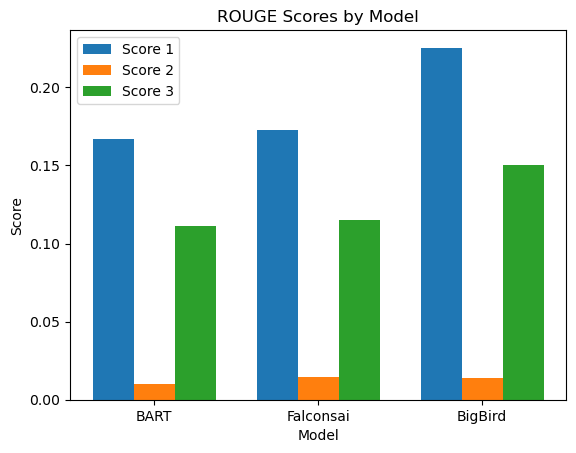

In [37]:
# Create a chart to compare the scores

models = ["BART", "Falconsai", "BigBird"]
scores_1 = [bart_scores["rouge1"], falconsai_scores["rouge1"], bigbird_scores["rouge1"]]
scores_2 = [bart_scores["rouge2"], falconsai_scores["rouge2"], bigbird_scores["rouge2"]]
scores_l = [bart_scores["rougeL"], falconsai_scores["rougeL"], bigbird_scores["rougeL"]]
scores = [scores_1, scores_2, scores_l]

fig, ax = plt.subplots()
bar_width = 0.25
index = range(len(models))

for i, score in enumerate(scores):
    ax.bar([x + bar_width * i for x in index], score, bar_width, label=f"Score {i + 1}")

ax.set_xlabel("Model")
ax.set_ylabel("Score")
ax.set_title("ROUGE Scores by Model")
ax.set_xticks([x + bar_width for x in index])
ax.set_xticklabels(models)
ax.legend()

plt.show()

In [38]:
# extract the article_id, abstract, and full_text columns into a new DataFrame
df_nlp = df_articles[["article_id", "full_text", "ABSTRACT"]]
df_nlp.head()

,article_id,full_text,ABSTRACT
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ..."
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...
3,PMC11240861,Research progress of DNA methylation in colore...,DNA methylation is one of the earliest and mos...
4,PMC11289611,"Investigating the Relationship of Serum CD163,...","Objective, This study aimed to compare serum l..."


In [39]:
# save the dataframe to a .csv file
df_nlp.to_csv("articles.csv", index=False)

In [40]:
X = df_nlp["full_text"]
y = df_nlp["ABSTRACT"]

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## To do: Fine-tuning LLM for our use case
